In [7]:
from gensim.models import Word2Vec

import numpy as np
import re
import os

import urllib.request
import zipfile
import lxml.etree

import matplotlib.pyplot as pyplot
from matplotlib.mlab import PCA
from sklearn.manifold import MDS

In [ ]:
# Download the dataset if it's not already there: this may take a minute as it is 75MB
if not os.path.isfile('ted_en-20160408.zip'):
    urllib.request.urlretrieve("https://wit3.fbk.eu/get.php?path=XML_releases/xml/ted_en-20160408.zip&filename=ted_en-20160408.zip", filename="ted_en-20160408.zip")

# For now, we're only interested in the subtitle text, so let's extract that from the XML:
with zipfile.ZipFile('ted_en-20160408.zip', 'r') as z:
    doc = lxml.etree.parse(z.open('ted_en-20160408.xml', 'r'))
input_text = '\n'.join(doc.xpath('//content/text()'))
del doc

input_text_noparens = re.sub(r'\([^)]*\)', '', input_text)

sentences_strings_ted = []
for line in input_text_noparens.split('\n'):
    m = re.match(r'^(?:(?P<precolon>[^:]{,20}):)?(?P<postcolon>.*)$', line)
    sentences_strings_ted.extend(sent for sent in m.groupdict()['postcolon'].split('.') if sent)

del input_text, input_text_noparens

sentences_ted = []
for sent_str in sentences_strings_ted:
    tokens = re.sub(r"[^a-z0-9]+", " ", sent_str.lower()).split()
    sentences_ted.append(tokens)

model_ted = Word2Vec(sentences_ted, size=29, min_count=10)
model_ted.init_sims(replace=True)

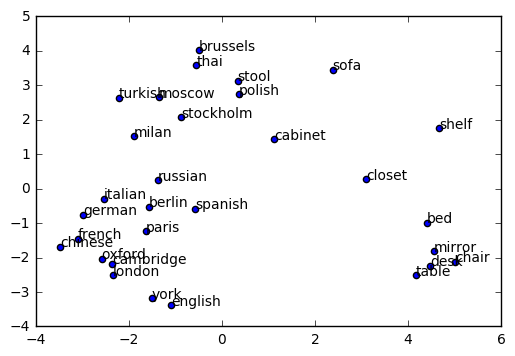

In [8]:
# 30 words: 10 in each of 3 categories (languages, furtniture, cities)
words = [
    'english','french','german','italian','spanish','russian','turkish','polish','chinese','thai',
    'table', 'chair', 'sofa', 'stool', 'bed', 'closet', 'shelf', 'desk', 'mirror', 'cabinet',
    'berlin','paris','london','milan','brussels','stockholm','moscow','york','oxford','cambridge'
]

words_vec = []

for w in words:
    words_vec.append(model_ted.wv[w])

vecs = np.array(words_vec)
    
pca = PCA(vecs)

def plot_me(coords, annot):
    pyplot.scatter(coords[:,0], coords[:,1])
    i = 0
    for a in annot:
        if a == 'German':
            continue
        pyplot.annotate(a, (coords[i][0], coords[i][1]))
        i += 1
    pyplot.show()
    
plot_me(pca.Y, words)

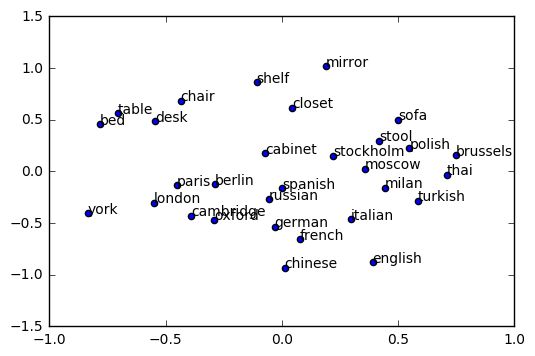

In [9]:
# Computing the distance matrix using Euclidean norm
dist_matrix = np.zeros((len(words), len(words)))
for i in range(len(words)):
    for j in range(len(words)):
        if i != j:
            dist_matrix[i][j] = np.linalg.norm(words_vec[i] - words_vec[j])

# Performing Multidimensional scaling on the same set of words
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=6)
res = mds.fit(dist_matrix)

coords = res.embedding_

plot_me(coords, words)